# Capstone Project - The Paris Job

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)



## Introduction: Business Problem <a name="introduction"></a>

In this project we are trying to start a new job in Paris. Lets say that we want to open a shop of some job. To help us deside what kind of shop to open, we will examine all Paris venues to see what is the most common type of shops, so we decide to start this kind of shops.
Second, will try to find an optimal location this shop. Specifically, this report will be targeted to stakeholders interested in opening a **new shop** in **Paris**, France.

Since there are lots of shops in Paris we will try to detect **areas with no this type of shops in vicinity**. We would also prefer locations **as close to city center as possible**, assuming that first two conditions are met.

We will use our data science powers to generate a few most promissing neighborhoods based on this criteria. Advantages of each area will then be clearly expressed so that best possible final location can be chosen by stakeholders.

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decission are:
* number of and distance to shops in the neighborhood, if any
* distance of neighborhood from city center

We decided to use regularly spaced grid of locations, centered around city center, to define our neighborhoods.

Following data sources will be needed to extract/generate the required information:
* centers of candidate areas will be generated algorithmically and approximate addresses of centers of those areas will be obtained.
* number of restaurants and their type and location in every neighborhood will be obtained using **Foursquare API**
* coordinate of Paris center will be obtained manually using **Geo PyNominatim** that will point to the center of Paris

### Neighborhood Candidates

Let's create latitude & longitude coordinates for centroids of our candidate neighborhoods. We will create a grid of cells covering our area of interest which is aprox. 12x12 killometers centered around Paris city center.


In [28]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import matplotlib as mpl
import matplotlib.pyplot as plt

In [8]:
address = 'Paris, France'

geolocator = Nominatim(user_agent="paris_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Paris are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Paris are 48.8566969, 2.3514616.


In [9]:
map_paris = folium.Map(location =[latitude,longitude], zoom_start = 11)
map_paris

In [2]:
latitude = 48.8566969
longitude = 2.3514616
paris_center = [latitude , longitude]
#paris_center = [48.8566969, 2.3514616]

Now let's create a grid of area candidates, equaly spaced, centered around city center and within ~6km from Paris center. Our neighborhoods will be defined as circular areas with a radius of 300 meters, so our neighborhood centers will be 800 meters apart.

To accurately calculate distances we need to create our grid of locations in Cartesian 2D coordinate system which allows us to calculate distances in meters (not in latitude/longitude degrees). Then we'll project those coordinates back to latitude/longitude degrees to be shown on Folium map. So let's create functions to convert between WGS84 spherical coordinate system (latitude/longitude degrees) and UTM Cartesian coordinate system (X/Y coordinates in  meters).

In [3]:
import shapely.geometry

#!pip install pyproj
import pyproj

import math

def lonlat_to_xy(lon, lat):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=33, datum='WGS84')
    xy = pyproj.transform(proj_latlon, proj_xy, lon, lat)
    return xy[0], xy[1]

def xy_to_lonlat(x, y):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=33, datum='WGS84')
    lonlat = pyproj.transform(proj_xy, proj_latlon, x, y)
    return lonlat[0], lonlat[1]

def calc_xy_distance(x1, y1, x2, y2):
    dx = x2 - x1
    dy = y2 - y1
    return math.sqrt(dx*dx + dy*dy)

print('Coordinate transformation check')
print('-------------------------------')
print('Paris center longitude={}, latitude={}'.format(paris_center[1], paris_center[0]))
x, y = lonlat_to_xy(paris_center[1], paris_center[0])
print('Paris center UTM X={}, Y={}'.format(x, y))
lo, la = xy_to_lonlat(x, y)
print('Paris center longitude={}, latitude={}'.format(lo, la))

Coordinate transformation check
-------------------------------
Paris center longitude=2.3514616, latitude=48.8566969
Paris center UTM X=-426736.18866927875, Y=5489149.384570399
Paris center longitude=2.3514616000000026, latitude=48.856696899999996


Let's create a **hexagonal grid of cells**: we offset every other row, and adjust vertical row spacing so that **every cell center is equally distant from all it's neighbors**.

In [4]:
paris_center_x, paris_center_y = lonlat_to_xy(paris_center[1], paris_center[0]) # City center in Cartesian coordinates

k = math.sqrt(3) / 2 # Vertical offset for hexagonal grid cells
min = 6000
x_min = paris_center_x - min
x_step = 800
y_min = paris_center_y - min - (int(21/k)*k*800 - 12000)/2
y_step = 800 * k 

latitudes = []
longitudes = []
distances_from_center = []
xs = []
ys = []
for i in range(0, int(21/k)):
    y = y_min + i * y_step
    x_offset = (x_step/2) if i%2==0 else 0
    for j in range(0, 21):
        x = x_min + j * x_step + x_offset
        distance_from_center = calc_xy_distance(paris_center_x, paris_center_y, x, y)
        if (distance_from_center <= 6001):
            lon, lat = xy_to_lonlat(x, y)
            latitudes.append(lat)
            longitudes.append(lon)
            distances_from_center.append(distance_from_center)
            xs.append(x)
            ys.append(y)

print(len(latitudes), 'candidate neighborhood centers generated.')

199 candidate neighborhood centers generated.


Let's visualize the data we have so far: city center location and candidate neighborhood centers:

In [67]:
map_paris_1 = folium.Map(location=paris_center, zoom_start=13)
folium.Marker(paris_center, popup='Paris Center').add_to(map_paris_1)
for lat, lon in zip(latitudes, longitudes):
    folium.Circle([lat, lon], radius=(x_step/2), color='blue', fill=False).add_to(map_paris_1)
map_paris_1

OK, we now have the coordinates of centers of neighborhoods/areas to be evaluated, equally spaced (distance from every point to it's neighbors is exactly the same) and within ~6km from Paris center. 

For simplicity, we will name these locations Paris0 to Paris198.

In [5]:
paris_data = pd.DataFrame(columns=['Neighborhood','Latitude','Longitude'])
paris_data['Latitude'] = latitudes
paris_data['Longitude'] = longitudes
for i in range(0,len(latitudes) ):
    paris_data.loc[i,'Neighborhood'] = 'Paris'+ str(i)

In [6]:
LIMIT=100

In [7]:
paris_data.head()

,Neighborhood,Latitude,Longitude
0,Paris0,48.805676,2.342644
1,Paris1,48.806862,2.353274
2,Paris2,48.808047,2.363905
3,Paris3,48.809231,2.374537
4,Paris4,48.810415,2.385170


Looking good. Let's now place all this into a Pandas dataframe.

In [8]:
import pandas as pd

df_locations = pd.DataFrame({'Address': paris_data['Neighborhood'],
                             'Latitude': latitudes,
                             'Longitude': longitudes,
                             'X': xs,
                             'Y': ys,
                             'Distance from center': distances_from_center})

df_locations.head(10)

,Address,Latitude,Longitude,X,Y,Distance from center
0,Paris0,48.805676,2.342644,-428336.188669,5.483607e+06,5768.882041
1,Paris1,48.806862,2.353274,-427536.188669,5.483607e+06,5600.000000
2,Paris2,48.808047,2.363905,-426736.188669,5.483607e+06,5542.562584
3,Paris3,48.809231,2.374537,-425936.188669,5.483607e+06,5600.000000
4,Paris4,48.810415,2.385170,-425136.188669,5.483607e+06,5768.882041
5,Paris5,48.809975,2.325141,-429536.188669,5.484300e+06,5600.000000
6,Paris6,48.811163,2.335772,-428736.188669,5.484300e+06,5245.950819
7,Paris7,48.812350,2.346403,-427936.188669,5.484300e+06,4995.998399
8,Paris8,48.813536,2.357035,-427136.188669,5.484300e+06,4866.210024
9,Paris9,48.814721,2.367668,-426336.188669,5.484300e+06,4866.210024


### Foursquare
Now that we have our location candidates, let's use Foursquare API to get info on venues in each neighborhood.


Foursquare credentials are defined in hidden cell bellow.

In [66]:
CLIENT_ID = 'S2ZHJVSBY45V1BCP2D1XWCWFH34LULHFCYAMXQRVL2ZHX11V' # your Foursquare ID
CLIENT_SECRET = 'CSQID4JG02EF32OX0J2IZIFXP4R5KDD433QIWL3VNTOZBASL' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' )
print('CLIENT_SECRET:')

Your credentails:
CLIENT_ID: 
CLIENT_SECRET:


In [9]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [65]:
paris_venues = getNearbyVenues(names=paris_data['Neighborhood'],
                                   latitudes=paris_data['Latitude'],
                                   longitudes=paris_data['Longitude']
                                  )


Paris0
Paris1
Paris2
Paris3
Paris4
Paris5
Paris6
Paris7
Paris8
Paris9
Paris10
Paris11
Paris12
Paris13
Paris14
Paris15
Paris16
Paris17
Paris18
Paris19
Paris20
Paris21
Paris22
Paris23
Paris24
Paris25
Paris26
Paris27
Paris28
Paris29
Paris30
Paris31
Paris32
Paris33
Paris34
Paris35
Paris36
Paris37
Paris38
Paris39
Paris40
Paris41
Paris42
Paris43
Paris44
Paris45
Paris46
Paris47
Paris48
Paris49
Paris50
Paris51
Paris52
Paris53
Paris54
Paris55
Paris56
Paris57
Paris58
Paris59
Paris60
Paris61
Paris62
Paris63
Paris64
Paris65
Paris66
Paris67
Paris68
Paris69
Paris70
Paris71
Paris72
Paris73
Paris74
Paris75
Paris76
Paris77
Paris78
Paris79
Paris80
Paris81
Paris82
Paris83
Paris84
Paris85
Paris86
Paris87
Paris88
Paris89
Paris90
Paris91
Paris92
Paris93
Paris94
Paris95
Paris96
Paris97
Paris98
Paris99
Paris100
Paris101
Paris102
Paris103
Paris104
Paris105
Paris106
Paris107
Paris108
Paris109
Paris110
Paris111
Paris112
Paris113
Paris114
Paris115
Paris116
Paris117
Paris118
Paris119
Paris120
Paris121
Paris122
Par

In [10]:
# paris_venues.to_csv('paris_venues_test.csv')
paris_venues = pd.read_csv('paris_venues_test.csv')
print(paris_venues.shape)
paris_venues.head()

(9150, 8)


,Unnamed: 0,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,Paris0,48.805676,2.342644,Skatepark d'Arcueil,48.806097,2.341609,Skate Park
1,1,Paris0,48.805676,2.342644,Centre Sportif François Vincent Raspail,48.805900,2.340608,Athletics & Sports
2,2,Paris0,48.805676,2.342644,Parc Départemental du Coteau de la Bièvre,48.806781,2.342727,Park
3,3,Paris0,48.805676,2.342644,Tourte & Petitin,48.803658,2.338440,Photography Studio
4,4,Paris0,48.805676,2.342644,Marin Beaux-Arts,48.801768,2.342825,Arts & Crafts Store


In [11]:
print('There are {} uniques categories.'.format(len(paris_venues['Venue Category'].unique())))

There are 355 uniques categories.


In [26]:
df_venues_cat = paris_venues.groupby('Venue Category').count().sort_values(by='Venue')

In [34]:
df_venues_cat

,Unnamed: 0,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,,
Jiangxi Restaurant,1,1,1,1,1,1,1
Rental Service,1,1,1,1,1,1,1
Mac & Cheese Joint,1,1,1,1,1,1,1
River,1,1,1,1,1,1,1
College Theater,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...
Bakery,279,279,279,279,279,279,279
Bar,317,317,317,317,317,317,317
Italian Restaurant,355,355,355,355,355,355,355


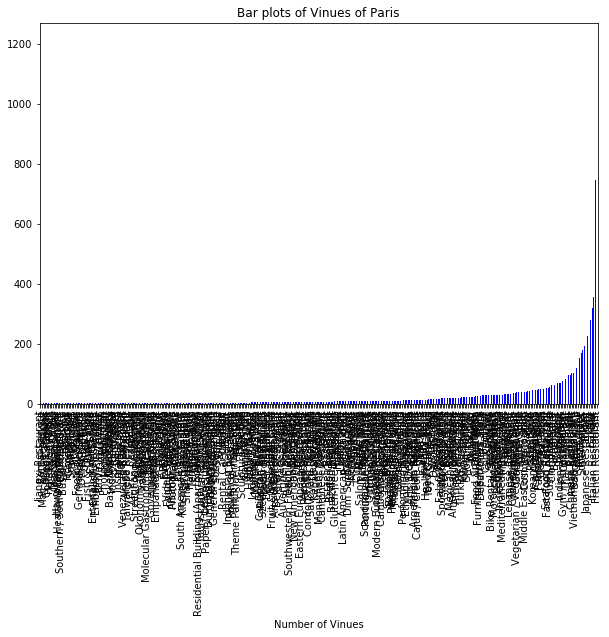

In [36]:
df_venues_cat['Venue'].plot(kind='bar', figsize=(10, 7), color='blue')

plt.title('Bar plots of Vinues of Paris')
plt.xlabel('Number of Vinues')

plt.show()

We will now check for the most common category

In [11]:
print(paris_venues['Venue Category'].value_counts().idxmax())
paris_venues['Venue Category'].value_counts().max()

French Restaurant


1208

We found that the most common category is **French Restaurant** so we will foucus in a place to start this job.

Lets extract the data for French restaurants

In [12]:
french_restaurant = paris_venues[paris_venues['Venue Category'].str.contains("French Restaurant")]
french_restaurant

,Unnamed: 0,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
5,5,Paris0,48.805676,2.342644,Le Patio Brasserie,48.810096,2.342963,French Restaurant
32,32,Paris2,48.808047,2.363905,Hippopotamus,48.812053,2.362346,French Restaurant
83,83,Paris7,48.812350,2.346403,Aux Foudres de Bacchus,48.814739,2.351580,French Restaurant
85,85,Paris7,48.812350,2.346403,La Terrasse du Marché,48.815978,2.350205,French Restaurant
104,104,Paris8,48.813536,2.357035,La Place Rouge,48.812639,2.361797,French Restaurant
...,...,...,...,...,...,...,...,...
9110,9110,Paris196,48.905344,2.338985,La Péricole,48.903057,2.336493,French Restaurant
9117,9117,Paris196,48.905344,2.338985,Chez Louisette,48.903007,2.343813,French Restaurant
9123,9123,Paris196,48.905344,2.338985,Café de l'Avenir,48.906125,2.332298,French Restaurant
9130,9130,Paris197,48.906532,2.349636,Le Comptoir,48.907469,2.344114,French Restaurant


In [46]:
xr = []
yr = []

for i in range(0, french_restaurant.shape[0]):
    lonr = french_restaurant.iloc[i,6]
    latr = french_restaurant.iloc[i,5]
    x, y = lonlat_to_xy(lonr, latr)
    xr.append(x)
    yr.append(y)

In [54]:
french_restaurant['Y'] = yr
french_restaurant['X'] = xr

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [13]:
#french_restaurant.to_csv('french_restaurant.csv')
french_restaurant = pd.read_csv('french_restaurant.csv',index_col=0)
french_restaurant

,Unnamed: 0.1,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Y,X
5,5,Paris0,48.805676,2.342644,Le Patio Brasserie,48.810096,2.342963,French Restaurant,5.484093e+06,-428230.051519
32,32,Paris2,48.808047,2.363905,Hippopotamus,48.812053,2.362346,French Restaurant,5.484070e+06,-426775.408592
83,83,Paris7,48.812350,2.346403,Aux Foudres de Bacchus,48.814739,2.351580,French Restaurant,5.484500e+06,-427512.771559
85,85,Paris7,48.812350,2.346403,La Terrasse du Marché,48.815978,2.350205,French Restaurant,5.484655e+06,-427590.159990
104,104,Paris8,48.813536,2.357035,La Place Rouge,48.812639,2.361797,French Restaurant,5.484142e+06,-426804.603443
...,...,...,...,...,...,...,...,...,...,...
9110,9110,Paris196,48.905344,2.338985,La Péricole,48.903057,2.336493,French Restaurant,5.494469e+06,-426960.996641
9117,9117,Paris196,48.905344,2.338985,Chez Louisette,48.903007,2.343813,French Restaurant,5.494373e+06,-426427.474789
9123,9123,Paris196,48.905344,2.338985,Café de l'Avenir,48.906125,2.332298,French Restaurant,5.494861e+06,-427209.747255
9130,9130,Paris197,48.906532,2.349636,Le Comptoir,48.907469,2.344114,French Restaurant,5.494864e+06,-426321.804774


In [14]:
print('Total number of French restaurants:', len(french_restaurant))

Total number of French restaurants: 1213


Let's now see all the collected restaurants in our area of interest on map.

In [17]:
map_paris_l = folium.Map(location=paris_center, zoom_start=12)
folium.Marker(paris_center, popup='Paris center').add_to(map_paris_l)
for lat, lon in zip(latitudes, longitudes):
    folium.Circle([lat, lon], radius=(x_step/2), color='blue', fill=False).add_to(map_paris_l)
for index , row in french_restaurant.iterrows():
    lat = row[5]; lon = row[6]
    color = 'red' 
    folium.CircleMarker([lat, lon], radius=3, color=color, fill=True, fill_color=color, fill_opacity=1).add_to(map_paris_l)
map_paris_l

So now we have all the french restaurants in area within few kilometers from Paris center. We also know which restaurants exactly are in vicinity of every neighborhood candidate center.

This concludes the data gathering phase - we're now ready to use this data for analysis to produce the report on optimal locations for a new French restaurant!

## Methodology <a name="methodology"></a>

In this project we will direct our efforts on detecting areas of Paris that have low French restaurant density. We will limit our analysis to area ~6km around city center.

In first step we have collected the required **data: location and type (category) of every restaurant within 6km from Paris center**. We have also **identified French restaurants** 
Second step in our analysis will be calculation and exploration of '**restaurant density**' across different areas of Paris - we will use **heatmaps** to identify a few promising areas close to center with low number of restaurants in general (*and* no French restaurants in vicinity) and focus our attention on those areas.

In third and final step we will focus on most promising areas and within those create **clusters of locations that meet some basic requirements**: we will take into consideration locations  **without French restaurants in radius of 400 meters**. We will present map of all such locations but also create clusters (using **k-means clustering**) of those locations to identify general zones / neighborhoods / addresses which should be a starting point for final 'street level' exploration and search for optimal venue location.

## Analysis <a name="analysis"></a>

Let's calculate the **distance to nearest French restaurant from every area candidate center** (not only those within 300m - we want distance to closest one, regardless of how distant it is).

In [18]:
distances_to_french_restaurant = []

for area_x, area_y in zip(xs, ys):
    min_distance = 100000
    for index, row in french_restaurant.iterrows():
        res_x, res_y= row[9], row[8]
        d = calc_xy_distance(area_x, area_y, res_x, res_y)
        if d<min_distance:
            min_distance = d
    distances_to_french_restaurant.append(min_distance)

df_locations['Distance to French restaurant'] = distances_to_french_restaurant

In [37]:
df_locations.head(10)

,Address,Latitude,Longitude,X,Y,Distance from center,Distance to French restaurant
0,Paris0,48.805676,2.342644,-428336.188669,5.483607e+06,5768.882041,497.160433
1,Paris1,48.806862,2.353274,-427536.188669,5.483607e+06,5600.000000,846.964613
2,Paris2,48.808047,2.363905,-426736.188669,5.483607e+06,5542.562584,464.710726
3,Paris3,48.809231,2.374537,-425936.188669,5.483607e+06,5600.000000,958.492533
4,Paris4,48.810415,2.385170,-425136.188669,5.483607e+06,5768.882041,592.796387
5,Paris5,48.809975,2.325141,-429536.188669,5.484300e+06,5600.000000,827.335186
6,Paris6,48.811163,2.335772,-428736.188669,5.484300e+06,5245.950819,546.876683
7,Paris7,48.812350,2.346403,-427936.188669,5.484300e+06,4995.998399,359.520051
8,Paris8,48.813536,2.357035,-427136.188669,5.484300e+06,4866.210024,367.363312
9,Paris9,48.814721,2.367668,-426336.188669,5.484300e+06,4866.210024,494.387946


In [38]:
print('Average distance to closest French restaurant from each area center:', df_locations['Distance to French restaurant'].mean())

Average distance to closest French restaurant from each area center: 267.07748285453914


OK, so **on average French restaurant can be found within ~270m** from every area center candidate. That's fairly close, so we need to filter our areas carefully!

Let's crete a map showing **heatmap / density of restaurants** and try to extract some meaningfull info from that. Also, let's show **borders of French boroughs** on our map and a few circles indicating distance of 1km, 2km and 3km from Paris center.

In [39]:
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

In [40]:
#paris_boroughs = requests.get('paris.geojson').json()
with open('paris.geojson') as json_data:
    paris_boroughs = json.load(json_data)
def boroughs_style(feature):
    return { 'color': 'blue', 'fill': False }

In [41]:
# restaurant_latlons = [[res[2], res[3]] for res in restaurants.values()]

french_latlons = [[row[5], row[6]] for indes, row in french_restaurant.iterrows()]

In [42]:
from folium import plugins
from folium.plugins import HeatMap

map_paris_h = folium.Map(location=paris_center, zoom_start=12)
folium.TileLayer('cartodbpositron').add_to(map_paris_h) #cartodbpositron cartodbdark_matter
HeatMap(french_latlons).add_to(map_paris_h)
folium.Marker(paris_center).add_to(map_paris_h)
folium.Circle(paris_center, radius=1000, fill=False, color='white').add_to(map_paris_h)
folium.Circle(paris_center, radius=2000, fill=False, color='white').add_to(map_paris_h)
folium.Circle(paris_center, radius=3000, fill=False, color='white').add_to(map_paris_h)
folium.GeoJson(paris_boroughs, style_function=boroughs_style, name='geojson').add_to(map_paris_h)
map_paris_h

Looks like a few pockets of low restaurant density closest to city center can be found **south, south-east and east from Paris center**. 


This map is so 'hot' (French restaurants are so common in Paris) but it also indicates higher density of existing French restaurants directly north and west from Paris center, with closest pockets of **low French restaurant density positioned south-east from city center**.

Based on this we will now focus our analysis on areas *south-east from Paris center* - we will move the center of our area of interest and reduce it's size to have a radius of **2.5km**. 

Let's define new, more narrow region of interest, which will include low-restaurant-count parts of south-east closest to Paris center.

In [47]:
roi_x_min = paris_center_x - 2000
roi_y_max = paris_center_y + 1500
roi_width = 5000
roi_height = 5000
roi_center_x = roi_x_min + 2500
roi_center_y = roi_y_max - 2500
roi_center_lon, roi_center_lat = xy_to_lonlat(roi_center_x, roi_center_y)
roi_center = [roi_center_lat, roi_center_lon]

map_paris = folium.Map(location=roi_center, zoom_start=12)
HeatMap(french_latlons).add_to(map_paris)
folium.Marker(paris_center).add_to(map_paris)
folium.Circle(roi_center, radius=2500, color='white', fill=True, fill_opacity=0.4).add_to(map_paris)
folium.GeoJson(paris_boroughs, style_function=boroughs_style, name='geojson').add_to(map_paris)
map_paris

Not bad - this nicely covers all the pockets of low restaurant density in south-east Paris center.

Let's also create new, more dense grid of location candidates restricted to our new region of interest (let's make our location candidates 100m appart).

In [59]:
k = math.sqrt(3) / 2 # Vertical offset for hexagonal grid cells
x_step = 100
y_step = 100 * k 
roi_y_min = roi_center_y - 2500

roi_latitudes = []
roi_longitudes = []
roi_xs = []
roi_ys = []
for i in range(0, int(51/k)):
    y = roi_y_min + i * y_step
    x_offset = 50 if i%2==0 else 0
    for j in range(0, 51):
        x = roi_x_min + j * x_step + x_offset
        d = calc_xy_distance(roi_center_x, roi_center_y, x, y)
        if (d <= 2501):
            lon, lat = xy_to_lonlat(x, y)
            roi_latitudes.append(lat)
            roi_longitudes.append(lon)
            roi_xs.append(x)
            roi_ys.append(y)

print(len(roi_latitudes), 'candidate neighborhood centers generated.')

2261 candidate neighborhood centers generated.


OK. Now let's calculate the most important thing for each location candidate: **distance to closest French restaurant**.

In [49]:

def find_nearest_restaurant(x, y, restaurants):
    d_min = 100000
    for index, res in french_restaurant.iterrows():
        res_x = res[9]; res_y = res[8]
        d = calc_xy_distance(x, y, res_x, res_y)
        if d<=d_min:
            d_min = d
    return d_min


roi_french_distances = []

print('Generating data on location candidates... ', end='')
for x, y in zip(roi_xs, roi_ys):
    distance = find_nearest_restaurant(x, y, french_restaurant)
    roi_french_distances.append(distance)
print('done.')


Generating data on location candidates... done.


In [50]:
# Let's put this into dataframe
df_roi_locations = pd.DataFrame({'Latitude':roi_latitudes,
                                 'Longitude':roi_longitudes,
                                 'X':roi_xs,
                                 'Y':roi_ys,
                                 'Distance to French restaurant':roi_french_distances})

df_roi_locations.head(10)

,Latitude,Longitude,X,Y,Distance to French restaurant
0,48.826643,2.365306,-426286.188669,5.485649e+06,144.242481
1,48.826791,2.366635,-426186.188669,5.485649e+06,244.213108
2,48.826588,2.357800,-426836.188669,5.485736e+06,74.526261
3,48.826736,2.359129,-426736.188669,5.485736e+06,59.005828
4,48.826884,2.360458,-426636.188669,5.485736e+06,59.038219
5,48.827032,2.361788,-426536.188669,5.485736e+06,133.912941
6,48.827181,2.363117,-426436.188669,5.485736e+06,82.260711
7,48.827329,2.364447,-426336.188669,5.485736e+06,124.903856
8,48.827477,2.365776,-426236.188669,5.485736e+06,151.141987
9,48.827625,2.367106,-426136.188669,5.485736e+06,189.596086


In [75]:
df_roi_locations

,Latitude,Longitude,X,Y,Restaurants nearby,Distance to French restaurant
0,48.822254,2.366427,-426286.188669,5.485149e+06,0,524.742340
1,48.822402,2.367757,-426186.188669,5.485149e+06,0,560.525353
2,48.822199,2.358922,-426836.188669,5.485236e+06,0,328.332626
3,48.822347,2.360251,-426736.188669,5.485236e+06,0,359.799839
4,48.822495,2.361580,-426636.188669,5.485236e+06,0,413.653884
...,...,...,...,...,...,...
2256,48.865805,2.357339,-426136.188669,5.490086e+06,5,48.071920
2257,48.865954,2.358669,-426036.188669,5.490086e+06,4,72.397450
2258,48.866102,2.359999,-425936.188669,5.490086e+06,4,63.563926
2259,48.866250,2.361330,-425836.188669,5.490086e+06,3,151.126949


OK. Let us now **filter** those locations: we're interested only in **locations with no French restaurants in radius of 400 meters**.

In [55]:

good_fr_distance = np.array(df_roi_locations['Distance to French restaurant']>=400)
print('Locations with no French restaurants within 400m:', good_fr_distance.sum())

good_locations = (good_fr_distance)


df_good_locations = df_roi_locations[good_locations]


Locations with no French restaurants within 400m: 55


Let's see how this looks on a map.

In [58]:
good_latitudes = df_good_locations['Latitude'].values
good_longitudes = df_good_locations['Longitude'].values

good_locations = [[lat, lon] for lat, lon in zip(good_latitudes, good_longitudes)]

map_paris = folium.Map(location=roi_center, zoom_start=13)
folium.TileLayer('cartodbpositron').add_to(map_paris)
HeatMap(french_latlons).add_to(map_paris)
folium.Circle(roi_center, radius=2500, color='white', fill=True, fill_opacity=0.6).add_to(map_paris)
folium.Marker(paris_center).add_to(map_paris)
for lat, lon in zip(good_latitudes, good_longitudes):
    folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_paris) 
folium.GeoJson(paris_boroughs, style_function=boroughs_style, name='geojson').add_to(map_paris)
map_paris

Looking good. We now have a bunch of locations fairly close to Paris center, and we know that each of those locations has no French restaurant closer than 400m. Any of those locations is a potential candidate for a new French restaurant, at least based on nearby competition.

Let's now show those good locations in a form of heatmap:

In [60]:
map_paris = folium.Map(location=roi_center, zoom_start=14)
HeatMap(good_locations, radius=25).add_to(map_paris)
folium.Marker(paris_center).add_to(map_paris)
for lat, lon in zip(good_latitudes, good_longitudes):
    folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_paris)
folium.GeoJson(paris_boroughs, style_function=boroughs_style, name='geojson').add_to(map_paris)
map_paris

Looking good. What we have now is a clear indication of zones with *no* French restaurants at all nearby.

Let us now **cluster** those locations to create **centers of zones containing good locations**. Those zones, their centers and addresses will be the final result of our analysis. 

In [61]:
from sklearn.cluster import KMeans

number_of_clusters = 9

good_xys = df_good_locations[['X', 'Y']].values
kmeans = KMeans(n_clusters=number_of_clusters, random_state=0).fit(good_xys)

cluster_centers = [xy_to_lonlat(cc[0], cc[1]) for cc in kmeans.cluster_centers_]

map_paris = folium.Map(location=roi_center, zoom_start=14)
folium.TileLayer('cartodbpositron').add_to(map_paris)
HeatMap(french_latlons).add_to(map_paris)
folium.Circle(roi_center, radius=2500, color='white', fill=True, fill_opacity=0.4).add_to(map_paris)
folium.Marker(paris_center).add_to(map_paris)
for lon, lat in cluster_centers:
    folium.Circle([lat, lon], radius=500, color='green', fill=True, fill_opacity=0.25).add_to(map_paris) 
for lat, lon in zip(good_latitudes, good_longitudes):
    folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_paris)
folium.GeoJson(paris_boroughs, style_function=boroughs_style, name='geojson').add_to(map_paris)
map_paris

In [62]:
cluster_centers

[(2.3430465618283134, 48.83080596947133),
 (2.3879601136587985, 48.842350949855984),
 (2.3644295778880533, 48.83742543401102),
 (2.3618373304389597, 48.84756102387516),
 (2.380589462604025, 48.83238378205037),
 (2.3373351850362627, 48.84775981193829),
 (2.3671673105273583, 48.833625836611134),
 (2.368501392530987, 48.83982056399196),
 (2.3409217273358576, 48.83643257329602)]

Not bad - our clusters represent groupings of most of the candidate locations and cluster centers are placed nicely in the middle of the zones 'rich' with location candidates.

Addresses of those cluster centers will be a good starting point for exploring the neighborhoods to find the best possible location based on neighborhood specifics.

Let's see those zones on a city map without heatmap, using shaded areas to indicate our clusters:

In [63]:
map_paris = folium.Map(location=roi_center, zoom_start=14)
folium.Marker(paris_center).add_to(map_paris)
for lat, lon in zip(good_latitudes, good_longitudes):
    folium.Circle([lat, lon], radius=250, color='#00000000', fill=True, fill_color='#0066ff', fill_opacity=0.07).add_to(map_paris)
for lat, lon in zip(good_latitudes, good_longitudes):
    folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_paris)
for lon, lat in cluster_centers:
    folium.Circle([lat, lon], radius=500, color='green', fill=False).add_to(map_paris) 
folium.GeoJson(paris_boroughs, style_function=boroughs_style, name='geojson').add_to(map_paris)
map_paris

This concludes our analysis. We have created 9 addresses representing centers of zones containing locations with no French restaurants nearby, all zones being fairly close to city center (all less than 4km from Paris center). Although zones are shown on map with a radius of ~500 meters (green circles), their shape is actually very irregular and their centers/addresses should be considered only as a starting point for exploring area neighborhoods in search for potential restaurant locations.

In [65]:
map_paris = folium.Map(location=roi_center, zoom_start=14)
folium.Circle(paris_center, radius=50, color='red', fill=True, fill_color='red', fill_opacity=1).add_to(map_paris)
#for lonlat, addr in zip(cluster_centers, candidate_area_addresses):
#    folium.Marker([lonlat[1], lonlat[0]], popup=addr).add_to(map_paris) 
for lat, lon in zip(good_latitudes, good_longitudes):
    folium.Circle([lat, lon], radius=250, color='#0000ff00', fill=True, fill_color='#0066ff', fill_opacity=0.05).add_to(map_paris)
map_paris

## Results and Discussion <a name="results"></a>

Our analysis shows that although there is a great number of restaurants in Paris, we found that the most common restaurant type if "French resaurant", so we decided to use this type of restaurants to start the new job in Paris.
Then we sarted to analyze the distribution of restaurants to find the best place to start the job. There are pockets of low restaurant density fairly close to city center. Highest concentration of restaurants was detected north and west from Paris center, so we focused our attention to areas south-east. 

After directing our attention to this more narrow area of interest (covering approx. 5x5km south-east from Paris center) we first created a dense grid of location candidates (spaced 100m appart); those locations were then filtered so that those with French restaurant closer than 400m were removed.

Those location candidates were then clustered to create zones of interest which contain greatest number of location candidates.

Result of all this is 9 zones containing largest number of potential new restaurant locations based on number of and distance to existing venues - French restaurants particularly. This, of course, does not imply that those zones are actually optimal locations for a new restaurant! Purpose of this analysis was to only provide info on areas close to Paris center but not crowded with existing restaurants (particularly French) - it is entirely possible that there is a very good reason for small number of restaurants in any of those areas, reasons which would make them unsuitable for a new restaurant regardless of lack of competition in the area. Recommended zones should therefore be considered only as a starting point for more detailed analysis which could eventually result in location which has not only no nearby competition but also other factors taken into account and all other relevant conditions met.

## Conclusion <a name="conclusion"></a>

Purpose of this project was to identify best type of jobs to start in Paris, thes to select areas close to center with low number of this type in order to aid stakeholders in narrowing down the search for optimal location for a new job.By analysing venues it was found that ""French restaurant" is the most common venues in Paris. By calculating restaurant density distribution from Foursquare data we have first identified general boroughs that justify further analysis (south-east Paris center), and then generated extensive collection of locations which satisfy some basic requirements regarding existing nearby restaurants. Clustering of those locations was then performed in order to create major zones of interest (containing greatest number of potential locations) and locations of those zone centers were created to be used as starting points for final exploration by stakeholders.

Final decission on optimal restaurant location will be made by stakeholders based on specific characteristics of neighborhoods and locations in every recommended zone, taking into consideration additional factors like attractiveness of each location (proximity to park or water), levels of noise / proximity to major roads, real estate availability, prices, social and economic dynamics of every neighborhood etc.